# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
import os, pathlib
os.environ["MPLCONFIGDIR"] = str(pathlib.Path.home()/".config"/"matplotlib"); pathlib.Path(os.environ["MPLCONFIGDIR"]).mkdir(parents=True, exist_ok=True)


import os, sys, time, datetime, json, random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from TreasureMaze import TreasureMaze, UP, RIGHT, DOWN, LEFT
from GameExperience import GameExperience

%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

np.set_printoptions(suppress=True, linewidth=120)

print("Python:", sys.version)
print("TF version:", tf.__version__)
print("NumPy:", np.__version__)
print("SEED =", SEED)

Python: 3.11.13 (main, Jun  3 2025, 18:38:25) [Clang 17.0.0 (clang-1700.0.13.3)]
TF version: 2.16.1
NumPy: 1.26.4
SEED = 42


The following code block contains an 8x8 matrix that will be used as a maze object:

In [2]:
# Cell 2 — Define maze and initialize environment 

maze = np.array([
    [1., 0., 1., 1., 1., 1., 1., 1.],
    [1., 0., 1., 1., 1., 0., 1., 1.],
    [1., 1., 1., 1., 0., 1., 0., 1.],
    [1., 1., 1., 0., 1., 1., 1., 1.],
    [1., 1., 0., 1., 1., 1., 1., 1.],
    [1., 1., 1., 0., 1., 0., 0., 0.],
    [1., 1., 1., 0., 1., 1., 1., 1.],
    [1., 1., 1., 1., 0., 1., 1., 1.]
])

start = (0, 1)        # starting position (row, col)
goal  = (7, 4)        # treasure position
traps = [(5, 7)]      # optional: add any trap coordinates here

env = TreasureMaze(grid=maze, start=start, goal=goal, traps=traps)

state_dim = env.nrows * env.ncols
n_actions = env.n_actions

print("Environment ready.")
print("Grid size:", env.nrows, "x", env.ncols)
print("State dimension:", state_dim)
print("Number of actions:", n_actions)

Environment ready.
Grid size: 8 x 8
State dimension: 64
Number of actions: 4


This helper function allows a visual representation of the maze object:

In [3]:
# Cell 3 — Visualization helper 

def show(env):
    plt.grid('on')
    nrows, ncols = env.grid.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, ncols, 1))
    ax.set_yticks(np.arange(0.5, nrows, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # copy grid so we can visualize
    canvas = np.copy(env.grid).astype(float)

    # mark visited cells
    for (r, c) in env.visited:
        canvas[r, c] = 0.6

    # mark pirate/agent position
    pr, pc = env.pos
    canvas[pr, pc] = 0.3

    # mark treasure
    gr, gc = env.goal
    canvas[gr, gc] = 0.9

    # mark traps (if any)
    for (tr, tc) in env.traps:
        canvas[tr, tc] = 0.2

    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img


The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [4]:
# Cell 4 — Action setup & epsilon 

# Actions already imported from TreasureMaze: UP, RIGHT, DOWN, LEFT
# So we just create a readable dictionary
actions_dict = {
    LEFT: "left",
    UP: "up",
    RIGHT: "right",
    DOWN: "down",
}

# Number of actions comes from the environment
num_actions = env.n_actions

# Exploration factor (epsilon-greedy)
epsilon = 0.1

print("Number of actions:", num_actions)
print("Actions dict:", actions_dict)
print("Initial epsilon:", epsilon)



Number of actions: 4
Actions dict: {3: 'left', 0: 'up', 1: 'right', 2: 'down'}
Initial epsilon: 0.1


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

Initial state shape: (1, 64)
Reward after moving DOWN: -1.0
Game over? False


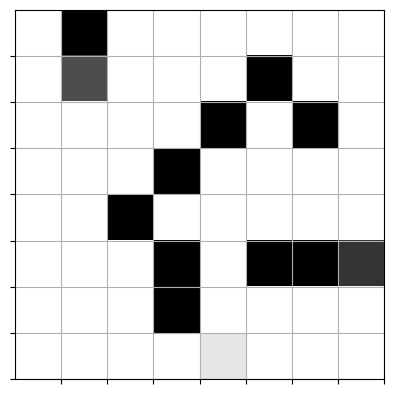

In [5]:
# Cell 5 — Quick environment test 

# reset environment
state = env.reset(seed=SEED)
print("Initial state shape:", state.shape)

# take one step (DOWN as test)
next_state, reward, done, info = env.step(DOWN)
print("Reward after moving DOWN:", reward)
print("Game over?", done)

# visualize
show(env)
plt.show()


This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [6]:
# Cell 6 — Evaluation rollout helper

def play_game(env, model, epsilon: float = 0.0, max_steps: int = 200, render: bool = False):
    """
    Run one episode using an epsilon-greedy policy.
    Returns: total_reward (float), steps (int), success (bool)
    """
    state = env.reset(seed=SEED)
    total = 0.0

    for t in range(max_steps):
        # ε-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.randint(env.n_actions)
        else:
            q = model.predict(state, verbose=0)[0]
            action = int(np.argmax(q))

        next_state, reward, done, _ = env.step(action)
        total += reward
        state = next_state

        if render:
            show(env)
            plt.show()
            print(f"step={t}, action={actions_dict[action]}, reward={reward:.2f}, done={done}")

        if done:
            return total, t + 1, True

    return total, max_steps, False


This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [7]:
# Cell 7 — Policy completion check

def completion_check(env, model, trials: int = 5, max_steps: int = 200) -> bool:
    """
    Run several greedy (epsilon=0) episodes from the default start.
    Returns True only if all trials reach the goal.
    """
    for i in range(trials):
        total, steps, success = play_game(env, model, epsilon=0.0, max_steps=max_steps, render=False)
        if not success:
            return False
    return True


The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [8]:
from tensorflow.keras.layers import PReLU

def build_model(state_dim, num_actions, lr=0.001):
    model = Sequential()
    model.add(Dense(state_dim, input_shape=(state_dim,)))
    model.add(PReLU())
    model.add(Dense(state_dim))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

# Build the model using env dimensions
model = build_model(state_dim, num_actions, lr=0.001)
model.summary()



/Users/niaz/Desktop/treasure hunt portfolio update/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-27 16:48:49.459803: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-09-27 16:48:49.459823: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-09-27 16:48:49.459829: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-09-27 16:48:49.459845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-27 16:48:49.459857: I tensorflow/core/common_runtime/pluggable_device/plugg

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 64)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 64)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,708 (34.02 KB)

 Trainable params: 8,708 (34.02 KB)

 Non-trainable params: 0 (0.00 B)

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [9]:
# Cell 9 — Training loop

def format_time(seconds):
    if seconds < 400:
        return f"{seconds:.1f} seconds"
    elif seconds < 4000:
        return f"{seconds/60.0:.2f} minutes"
    else:
        return f"{seconds/3600.0:.2f} hours"

def qtrain(env,
           model,
           episodes=200,
           max_steps=200,
           gamma=0.95,
           start_epsilon=1.0,
           min_epsilon=0.05,
           epsilon_decay=0.995,
           buffer_capacity=5000,
           batch_size=64,
           warmup=200,
           train_epochs=1,
           verbose=True):
    print("qtrain: starting…", flush=True)

    experience = GameExperience(model=model, max_memory=buffer_capacity, discount=gamma, seed=SEED)
    epsilon = start_epsilon
    returns, steps_hist, win_history = [], [], []

    t0 = time.time()
    for ep in range(1, episodes + 1):
        state = env.reset(seed=SEED + ep)
        total_reward = 0.0
        done = False

        for t in range(max_steps):
            if np.random.rand() < epsilon:
                action = np.random.randint(env.n_actions)
            else:
                q = model.predict(state, verbose=0)[0]
                action = int(np.argmax(q))

            next_state, reward, done, _ = env.step(action)
            experience.remember([state, action, reward, next_state, done])
            total_reward += reward
            state = next_state

            if len(experience) >= max(batch_size, warmup):
                inputs, targets = experience.get_data(batch_size=batch_size)
                model.fit(inputs, targets, epochs=train_epochs, verbose=0)

            if done:
                break

        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        returns.append(total_reward)
        steps_hist.append(t + 1)
        win_history.append(1 if done else 0)

        if verbose and (ep % 10 == 0 or ep == 1):
            win50 = np.mean(win_history[-50:]) if len(win_history) >= 50 else np.mean(win_history)
            print(f"EP {ep:03d} | return={total_reward:7.2f} | steps={t+1:3d} | eps={epsilon:.3f} | win50={win50:.2f}", flush=True)

        if len(win_history) >= 100 and np.mean(win_history[-100:]) >= 0.95:
            print(f"Early stop at EP {ep} (≥95% wins over last 100)", flush=True)
            break

    info = {
        "returns": np.array(returns),
        "steps":   np.array(steps_hist),
        "wins":    np.array(win_history),
        "duration": format_time(time.time() - t0),
    }
    print("qtrain: finished.", flush=True)
    return model, info

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

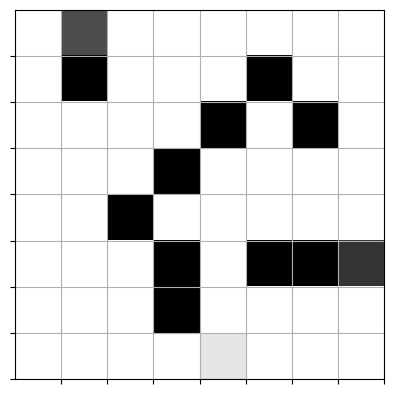

In [10]:
# Cell 10 — Environment visualization test

# Reset environment
env.reset(seed=SEED)

# Show the maze with agent start, treasure, and traps
show(env)
plt.show()


In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [ ]:
# Cell 11 — Train the model

# Build a fresh model (with proper Input layer to avoid warnings)
model = build_model(state_dim, num_actions, lr=0.001)

# Train using replay buffer + epsilon-greedy
trained_model, log = qtrain(
    env=env,
    model=model,
    episodes=500,        # you can start smaller to test quickly
    max_steps=200,       # max steps per episode
    gamma=0.95,          # discount factor
    start_epsilon=1.0,
    min_epsilon=0.05,
    epsilon_decay=0.995,
    buffer_capacity=5000,
    batch_size=64,
    warmup=200,
    train_epochs=1,
    verbose=True
)

print("Training complete in", log["duration"])


This cell will check to see if the model passes the completion check. Note: This could take several minutes.

In [ ]:
# Cell 12 — Completion check (REPLACE THIS CELL)

passed = completion_check(env, trained_model, trials=5, max_steps=200)
print("Completion check passed?", passed)

# Visualize final environment state
env.reset(seed=SEED)
show(env)
plt.show()

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

In [ ]:
# Cell 13 — Single-episode test (REPLACE THIS CELL)

# Optional: choose a custom starting cell (row, col)
pirate_start = (0, 0)

# Validate and apply the custom start (must be in-bounds and not a wall)
r, c = pirate_start
if 0 <= r < env.nrows and 0 <= c < env.ncols and env.grid[r, c] != 1:
    env.start = pirate_start
else:
    print(f"Invalid start {pirate_start}; using default start {env.start}")

# Run one greedy episode (epsilon=0.0)
total, steps, success = play_game(env, trained_model, epsilon=0.0, max_steps=200, render=False)
print(f"Single run -> success: {success}, return: {total:.2f}, steps: {steps}")

# Show final state after the episode
show(env)
plt.show()

In [ ]:
# Plot returns & epsilon
def moving_average(x, k=20):
    if len(x) < k: return x
    return np.convolve(x, np.ones(k)/k, mode="valid")

plt.figure(figsize=(8,4))
plt.plot(log["returns"], label="return")
ma = moving_average(log["returns"], k=20)
pad = [np.nan]*(len(log["returns"]) - len(ma))
plt.plot(pad + list(ma), label="return (MA20)")
plt.title("Training Return per Episode"); plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(np.linspace(0,1,len(log["returns"])), label="progress proxy", alpha=0)  # keep axes clean
plt.plot(np.linspace(0,1,len(log["returns"])), alpha=0)  # dummy to prevent style warnings


In [ ]:
# Evaluate N greedy episodes
N = 20
totals, steps, wins = [], [], 0
for _ in range(N):
    total, s, ok = play_game(env, trained_model, epsilon=0.0, max_steps=200, render=False)
    totals.append(total); steps.append(s); wins += int(ok)
print(f"Greedy eval: {wins}/{N} successes  |  Avg return: {np.mean(totals):.2f}  |  Avg steps: {np.mean(steps):.1f}")

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.